# Ball on incline

Estimate the Earth's gravitational acceleration through a Ball on incline experiment <br>
**Author(s), contact(s), dates** <br>
Silja Svendsen (wng830@alumni.ku.dk) <br>
03/12/2023 (latest update)

In [1]:
# import needed packages
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats

In [2]:
# import function library
sys.path.append('/Users/siljaxianpallisgaardsvendsen/Documents/KU_K/8_AppStat/AppStat2023/External_Functions/')
from ExternalFunctionsNew import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctionsNew import nice_string_output, add_text_to_ax   # Useful functions to print fit results on figure

In [3]:
# plotting settings
sns.set()
sns.set_context("paper", font_scale = 1.4)
sns.set_style("ticks")


save_plots = False
verbose = False

## Data

In [4]:
# position
position_array_x = [21.9, 36.95, 52.55, 69.35, 87.15] # cm test data taken from slides

In [5]:
# load time vs voltage data
data_ball_on_incline = []
for filepath in glob.glob('/Users/siljaxianpallisgaardsvendsen/Documents/KU_K/8_AppStat/AppStatProject1/*Ball1.txt'):
    data = np.loadtxt(filepath)
    data_ball_on_incline.append(data)

if (verbose):
    print(data_ball_on_incline)

In [6]:
# For readability
experiment_number = 0  # change this one for each experiment.
time = 0
voltage = 1

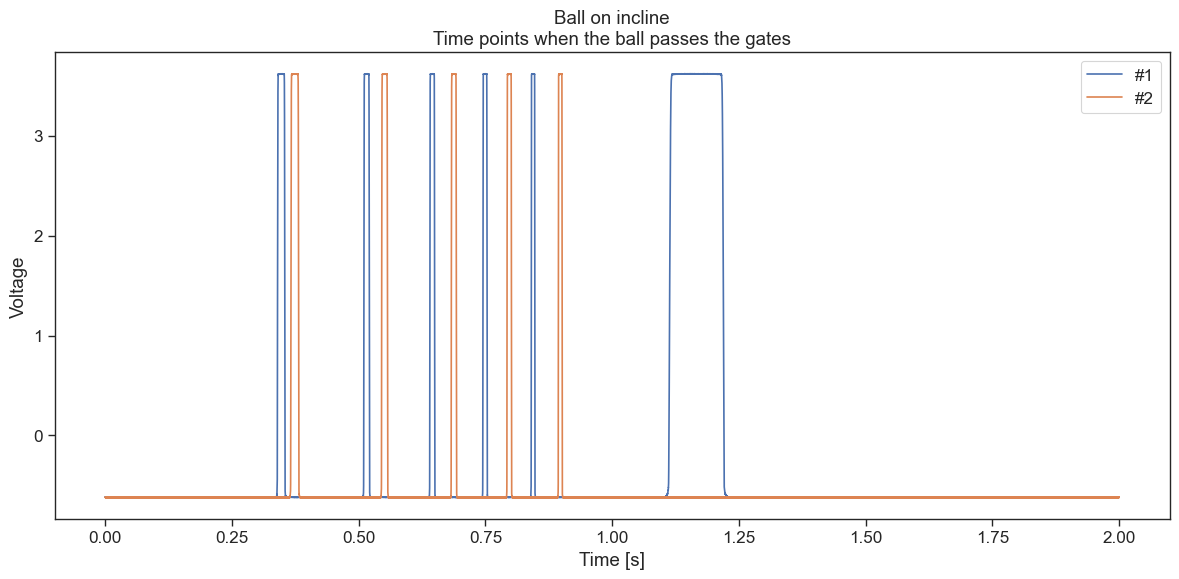

In [7]:
# plot the data to get an intuition
figure, axis = plt.subplots(figsize = (12,6))
axis.set(title = 'Ball on incline\nTime points when the ball passes the gates',
         ylabel = 'Voltage',
         xlabel = 'Time [s]')
for experiment_number in range(np.shape(data_ball_on_incline)[0]):
    axis.plot((data_ball_on_incline[experiment_number][:,time]),
             data_ball_on_incline[experiment_number][:,voltage], label = f'#{experiment_number+1}')
plt.legend()
plt.tight_layout()

# Save the data for each experiment

In [8]:
experiment_number = 1  # change this one for each time vs voltage experiment.


acc = []        # acceleration
sigacc = []     # uncertainty on acceleration

The angle can be measured using a 

In [9]:
## ------
#theta = []    
#sigtheta = []

#ball = []
#sigball = []

#rail = []
#sigrail = []

## Get time points of when the ball passes the gates
Well defined time points are obtained by reading the time at which it crosses a certain voltage.
For instance, U = 3V

In [10]:
# parameter
threshold_voltage = 3

# list to contain timepoints for one experiment
gate_passage_times = []

# for readability
voltage_array = data_ball_on_incline[experiment_number][:,voltage]
time_array = data_ball_on_incline[experiment_number][:,time]

# find timepoints
for datapoint in range(1, len(voltage_array)):
    if  voltage_array[datapoint] >  threshold_voltage > voltage_array[datapoint-1]:
        gate_passage_times.append(time_array[datapoint])  

## Get the acceleration of the ball
### Fit a parabola to a position vs time plot

In [11]:
def parabola_function(t, a, v0, s0):
    return 0.5*a*t**2 + v0*t + s0

In [22]:
# measurements
Npoints = 5
x = gate_passage_times

if len(x) != Npoints:
    print('There are too many gate passage times. Look at the data and see which one to exlude.')

y = position_array_x
sy = 0.1 * np.ones(len(x)) #uncertainty on position, how to obtain those? Here, I set it to 0.1 cm.

print(len(x), len(y), len(sy))

# Chi2
chi2 = Chi2Regression(parabola_function, x, y, sy)
minuit_para = Minuit(chi2, a= 1, v0 = 0, s0 = 0  ) # initial guess
minuit_para.errordef = Minuit.LEAST_SQUARES
minuit_para.migrad()

# sanity check
if (not minuit_para.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")
else :
    print("  The ChiSquare fit converged - congratulations")
    
    
# get fit parameters from minuit
a, v0, s0 = minuit_para.values[:]
print('Parabola fit')
for name in minuit_para.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_para.values[name],
                                                        minuit_para.errors[name]))

# get p-value
NDOF = Npoints - len(minuit_para.values[:])
chi2_val = minuit_para.fval
chi2_prob = stats.chi2.sf(chi2_val, NDOF)
print('p-value:', chi2_prob)


# append acceleration estimates and its error
acc.append(minuit_para.values[0])
sigacc.append(minuit_para.errors[0])

5 5 5
  The ChiSquare fit converged - congratulations
Parabola fit
Fit value: a = 242.61498 +/- 3.06279
Fit value: v0 = -29.63240 +/- 1.93948
Fit value: s0 = 16.56695 +/- 0.57474
p-value: 2.252868284038136e-08


In [23]:
# plot fit
x_fit = np.linspace(0, 1, 1000)
y_fit = parabola_function(x_fit, a, v0, s0)

# add fit results to plot
d = {'Entries':  Npoints,
     'Chi2':     chi2_val,
     'ndf':      NDOF,
     'Prob':     chi2_prob,
    }

for name in minuit_para.parameters:
    d[name] = [minuit_para.values[name], minuit_para.errors[name]]

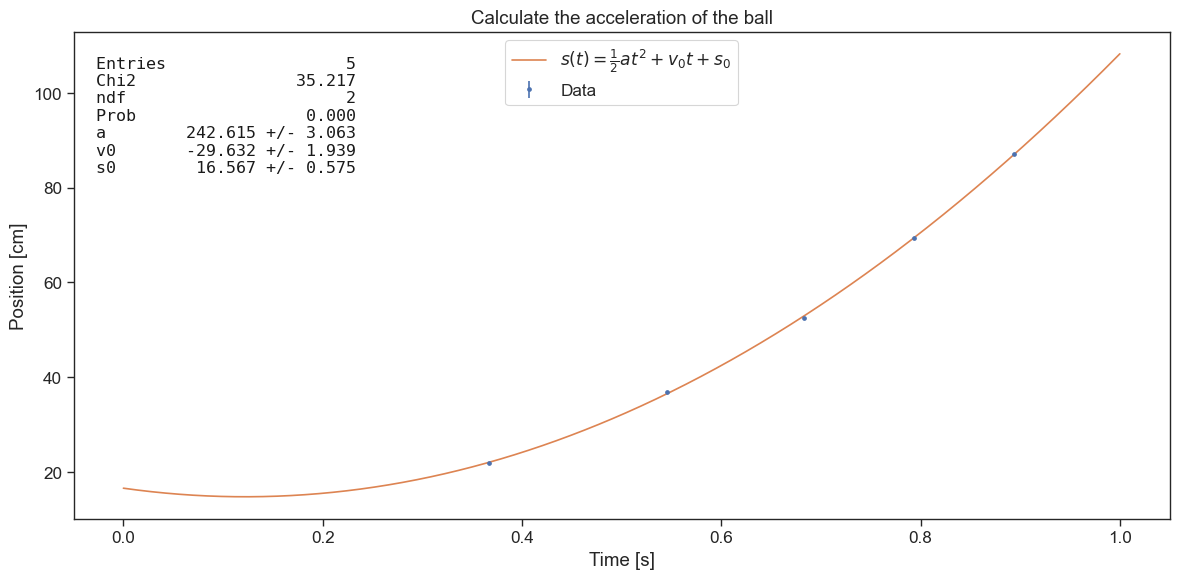

In [24]:
figure2, ax2 = plt.subplots(figsize = (12, 6))
ax2.set(title = 'Calculate the acceleration of the ball',
         ylabel = 'Position [cm]',
         xlabel = 'Time [s]')
ax2.errorbar(gate_passage_times, position_array_x, yerr = sy, fmt = '.', label = 'Data')
ax2.plot(x_fit, y_fit, label = r'$s(t) = \frac{1}{2}at^2 + v_0t +s_0$')
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax2, fontsize=12)
plt.legend(loc = 'upper center')
plt.tight_layout()
if save_plots:
    plt.savefig('position_time_x.png', dpi = 600)

# Determine g

In [15]:
def weighted_mean(measurement, error):
    '''Barlow eq. 4.6'''
    for xi,sigi in zip(measurement, error):
        mean = 0
        mean += (xi/sigi**2)/(1/sigi**2)
    return mean

def weighted_error(error):
    '''Barlow eq. 4.7'''
    for sigi in error:
        var = 0
        var += 1/(1/sigi**2)
    return np.sqrt(var)

In [16]:
from IPython.core.display import Latex

def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)

In [17]:
# parameters
#acc, theta, dtheta, dball, drail = 



In [18]:
'''
YOU NEED TO EDIT THIS ONE!
'''
# Import SymPy: 
from sympy import * 

# Define variables:
L,T, g = symbols("L, T, g")
dL,dT, dg = symbols("sigma_L, sigma_T, sigma_g")


# Define relation, and print:
g = L * (2*pi/T)**2

lprint(latex(Eq(symbols('g'),g)))

# Calculate uncertainty and print:
dg = sqrt((g.diff(L) * dL)**2 + (g.diff(T) * dT)**2 + 2* g.diff(L)*g.diff(T)*rhoTL*sigT*sigL)


lprint(latex(Eq(symbols('sigma_g'), dg)))

# Turn expression into numerical functions 
fg = lambdify((T,L),g)
fdg = lambdify((T,dT,L,dL),dg)

# Define values and their errors
vT, vdT = muT, sigT
vL, vdL = muL, sigL

# Numerically evaluate expressions and print 
vg = fg(vL,vT)
vdg = fdg(vL,vdL,vT,vdT)

lprint(fr'g = ({vg:.1f} \pm {vdg:.1f})\,\mathrm{{m}}')

<IPython.core.display.Latex object>

NameError: name 'rhoTL' is not defined